## Seminar 13. AlphaZero and MCTS


In [ ]:
import os
import math
import numpy as np
from random import shuffle

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

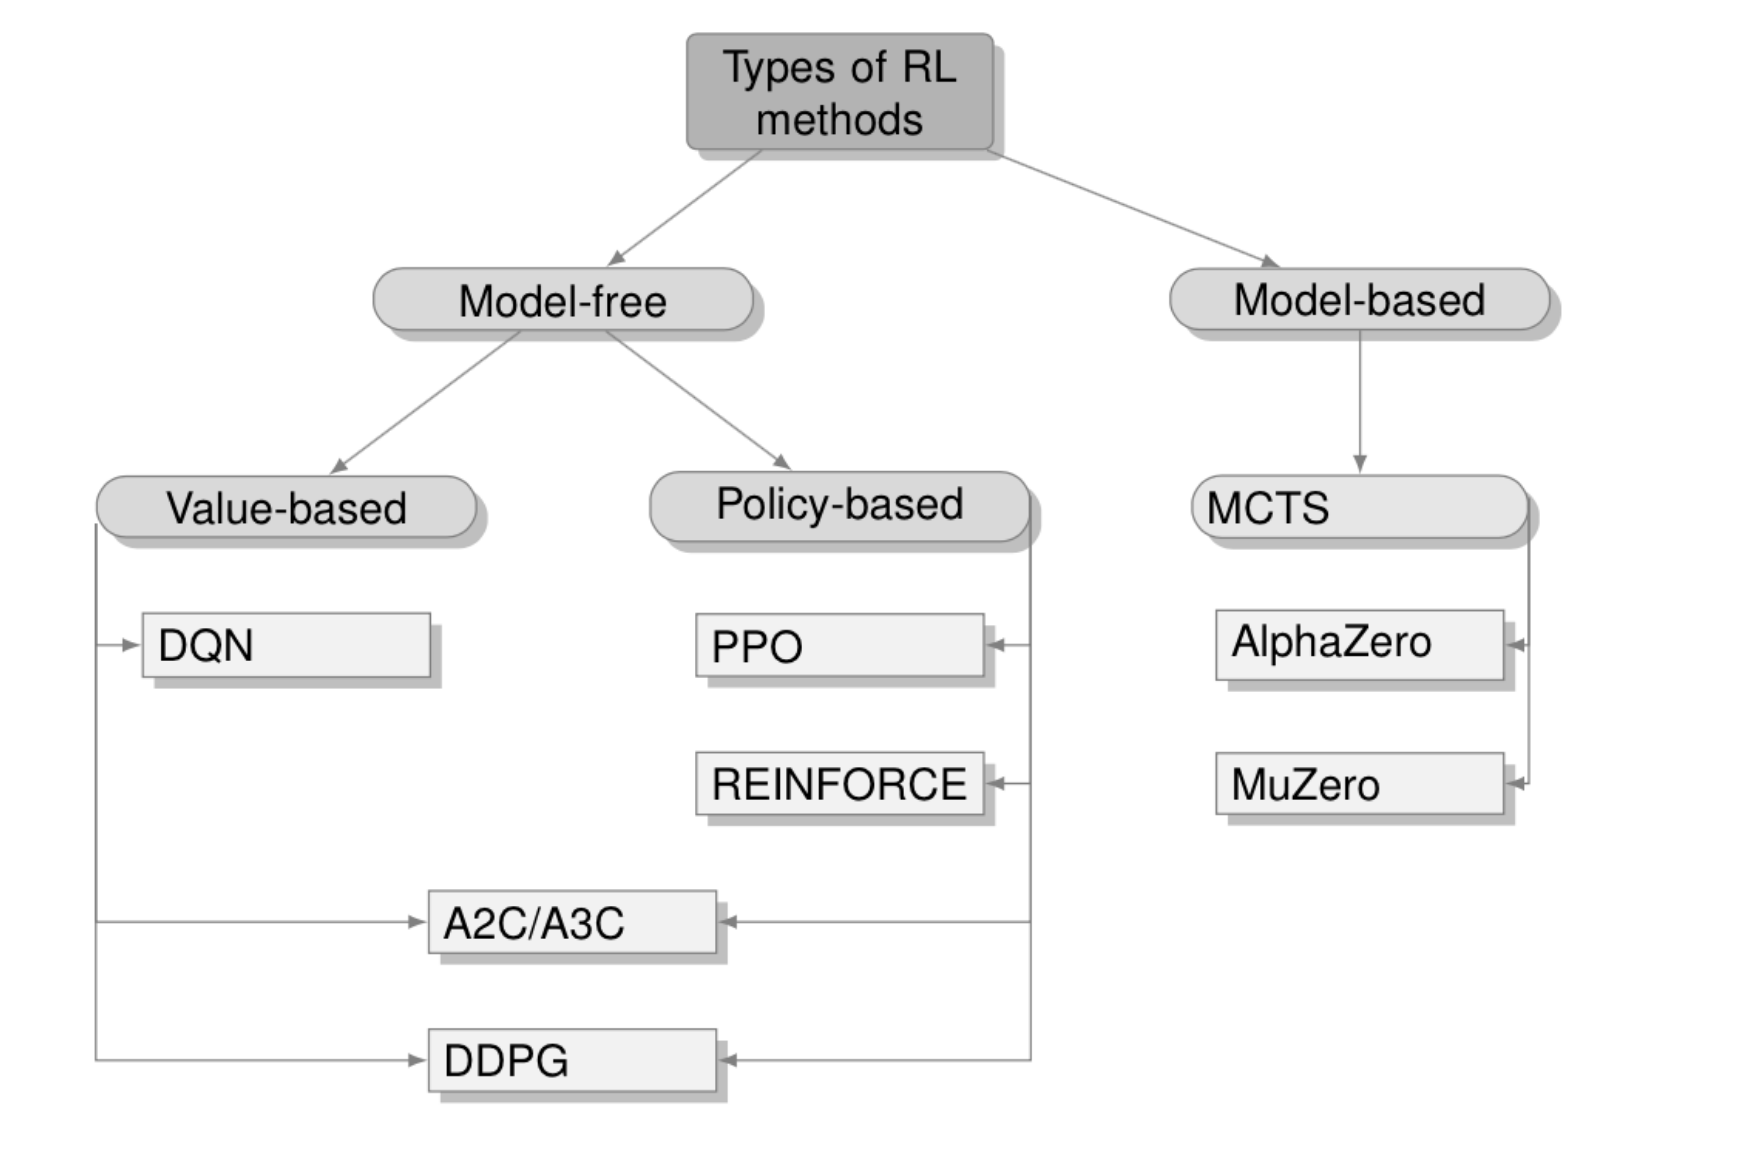

Today we will discuss **model-based** RL. A little bit of history:

* DeepMind's **[AlphaZero](https://deepmind.google/discover/blog/alphago-zero-starting-from-scratch/)** (2017)  elegantly solved such games through self-play without prior knowledge.
* Later, **[MuZero](https://deepmind.google/discover/blog/muzero-mastering-go-chess-shogi-and-atari-without-rules/)** (2020) extended this by removing the environment model requirement, broadening its applicability (e.g., Atari). MuZero's generality comes at the cost of more complex training and potentially longer times or less optimal results.
* **[AlphaTensor](https://deepmind.google/discover/blog/discovering-novel-algorithms-with-alphatensor/)** (2022) used AlphaZero's ides to discover novel and more efficient algorithms for matrix multiplication, even outperforming human-designed algorithms in some cases.
* **[AlphaDev](https://deepmind.google/discover/blog/alphadev-discovers-faster-sorting-algorithms/)** (2023) applied a similar approach to discover faster sorting algorithms, which have been integrated into standard C++ libraries, improving the efficiency of everyday computing.


To understand the core concepts of **AlphaZero**, we will analyze a very accessible example from  http://joshvarty.github.io/AlphaZero/.

## Model-based VS model-free

The core difference between **model-based** VS **model-free** lies in the "model" - a representation of the environment providing next states and rewards.

* **Model-free** methods learn behavior (policy or value) directly from environment interactions, which can be inefficient / time consuming.

* **Model-based** methods aim to learn this environment model, reducing reliance on real-world samples. A good model allows agents to *generate simulated trajectories*.

Key advantages of **model-based RL** are:

1. *sample efficiency* (reducing real-world interaction),

2. *model transferability* across tasks. If you have a good model for a robot manipulator, you can use it for a wide variety of goals without retraining everything from scratch.



## AlphaGo Zero method (Overview)

**AlphaGo Zero**, introduced by DeepMind in 2017 (https://deepmind.google/discover/blog/alphago-zero-starting-from-scratch/), achieved superhuman Go play by learning solely through self-play. The method has $3$ key components:

1. **Monte Carlo Tree Search (MCTS)** for selectively exploring the *vast game tree*.

2. A constantly evolving "*best player*" model used for **self-play** to generate training data (initially random, it improves over time).

3. An **"apprentice" model** trained on this self-play data.

Periodically, the apprentice is evaluated against the best player, and if it performs better, it becomes the new best player, continuing the cycle. This is a rough pipe-line:

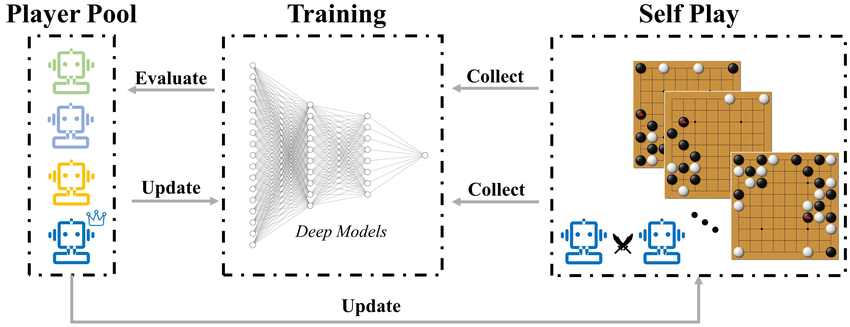

# Connect Game

We will study AlphaZero using the Connect game framework.

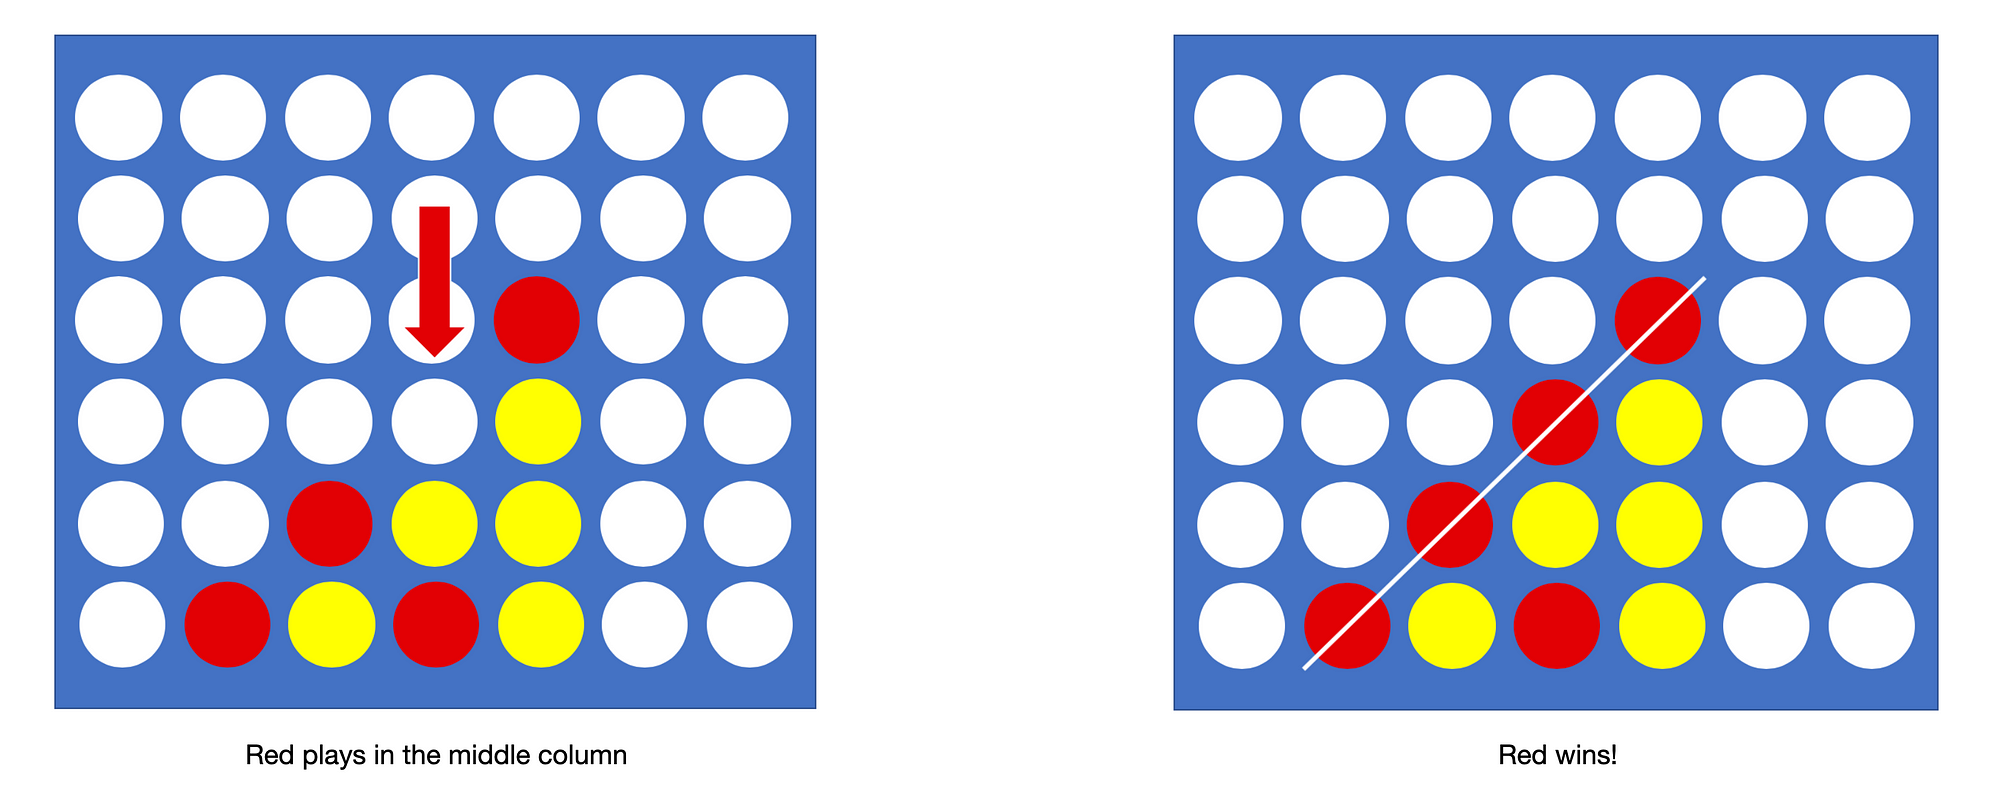

While Connect Four is feasible, it's too complex for this seminar. Therefore, we'll use the **1D Connect-K** game, where players aim to get K consecutive pieces of their color in a line of C columns. To keep it simple, our example will use C = 4 and K = 2.

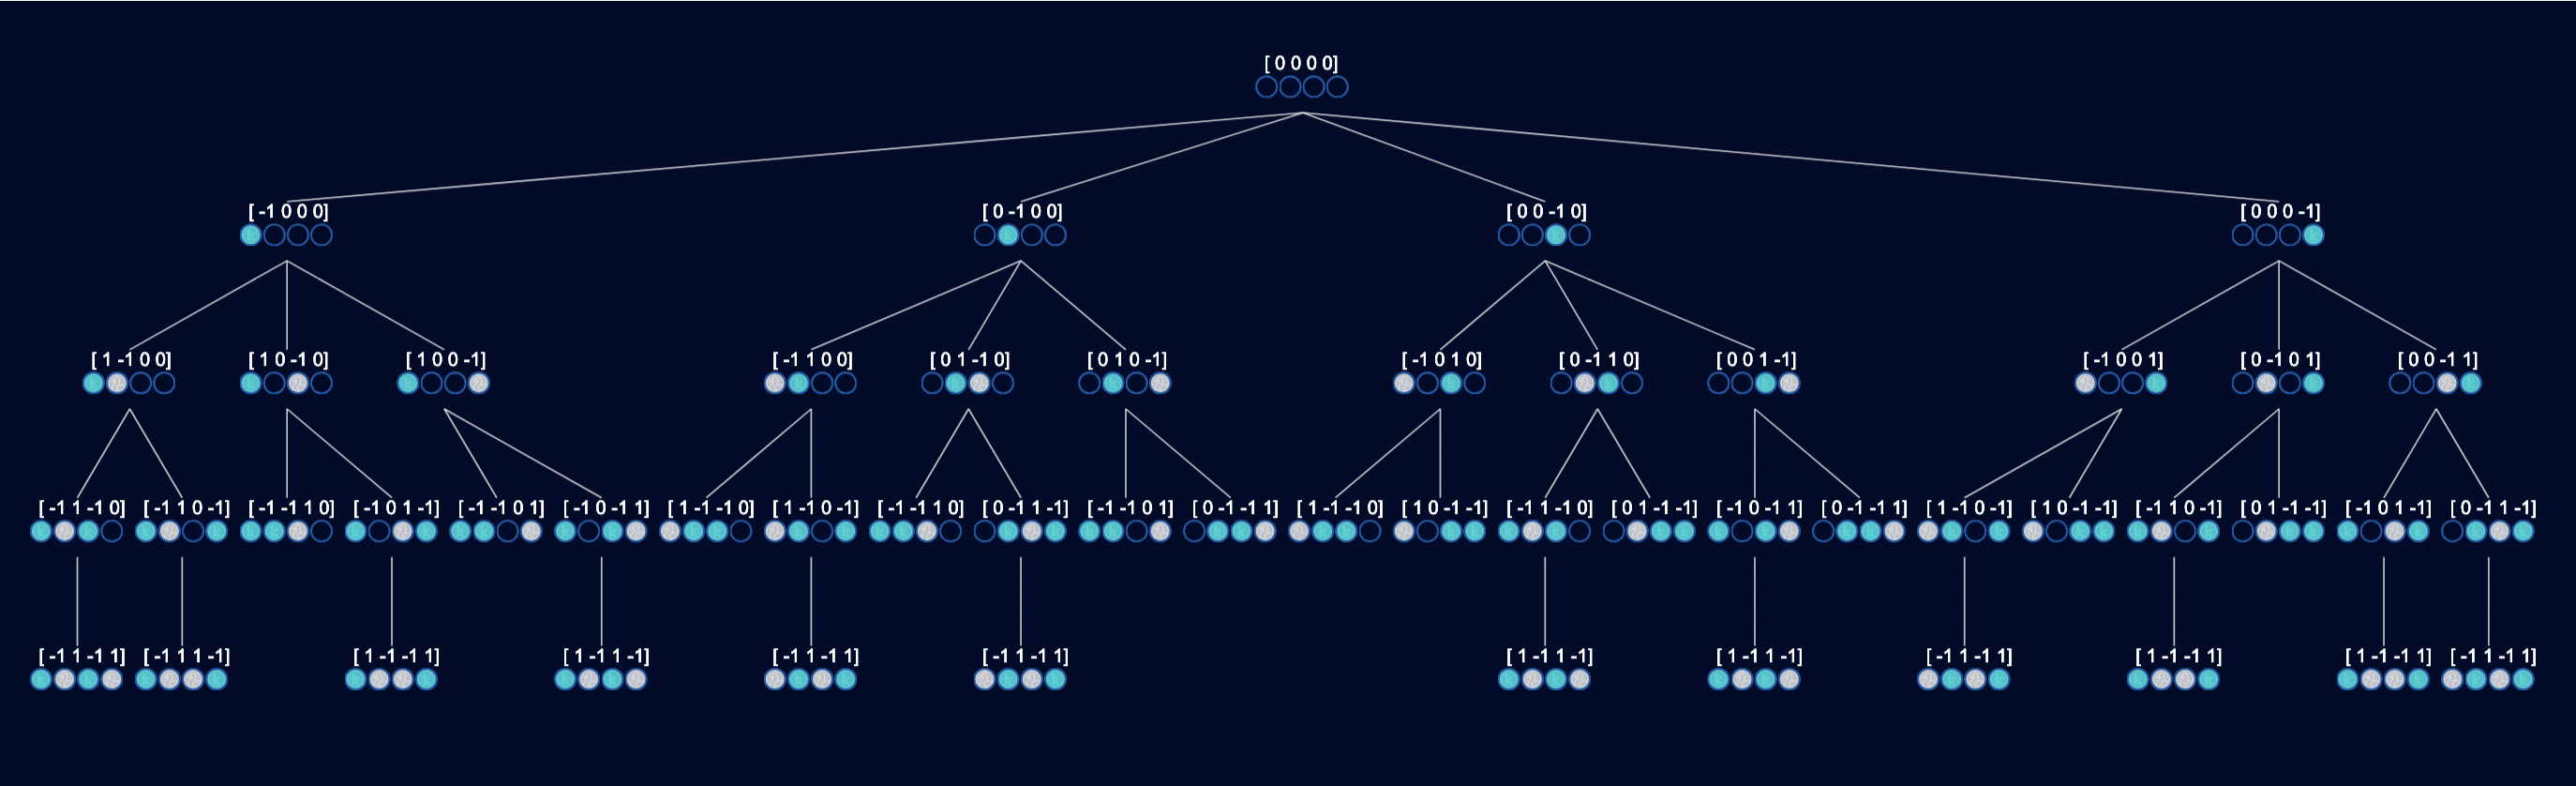

In our 1D Connect-K implementation, we represent the board as a list:
* Player's pieces are $1$, opponent's are $-1$, and empty spaces are $0$.

* The initial state is $[0, 0, 0, 0]$.

* Rewards are $+1$ for a win, $-1$ for a loss, and $0$ for a draw.

*Important Note*: The current player always views their pieces as $1$. To achieve this, we multiply the board state by $-1$ after each player's move.

In [ ]:
class Connect2Game:
    """
    A very, very simple game of ConnectX in which we have:
        rows: 1
        columns: 4
        winNumber: 2
    """

    def __init__(self, columns=4, win=2):
        self.columns = columns
        self.win = win

    def get_init_board(self):
        b = np.zeros((self.columns,), dtype=int)
        return b

    def get_board_size(self):
        return self.columns

    def get_action_size(self):
        return self.columns

    def get_next_state(self, board, player, action):
        b = np.copy(board)
        b[action] = player

        # Return the new game, but
        # change the perspective of the game with negative
        return (b, -player)

    def has_legal_moves(self, board):
        for index in range(self.columns):
            if board[index] == 0:
                return True
        return False

    def get_valid_moves(self, board):
        # All moves are invalid by default
        valid_moves = [0] * self.get_action_size()

        for index in range(self.columns):
            if board[index] == 0:
                valid_moves[index] = 1

        return valid_moves

    def is_win(self, board, player):
        count = 0
        for index in range(self.columns):
            if board[index] == player:
                count = count + 1
            else:
                count = 0

            if count == self.win:
                return True

        return False

    def get_reward_for_player(self, board, player):
        # return None if not ended, 1 if player 1 wins, -1 if player 1 lost

        if self.is_win(board, player):
            return 1
        if self.is_win(board, -player):
            return -1
        if self.has_legal_moves(board):
            return None

        return 0

    def get_canonical_board(self, board, player):
        return player * board

In AlphaGo Zero, the NN is used to approximate the prior probabilities of the actions and evaluate the position, which is very similar to the advantage **actor-critic (A2C)** two-headed setup. In the input of the network, we pass the current game position (maybe augmented, e.g. with previous positions) and return two values:

* The **policy head** returns the probability distribution over the actions.
* The **value head** estimates the game outcome as seen from the player's perspective.

Training:

* Training of the **value head** involves self-play, where the final game result (win/loss/draw) is used to label all preceding states for each player. The network learns to predict these final values for given states.
* The **policy head** is trained to mimic the move probabilities generated by MCTS during self-play, using Cross-Entropy Loss to align its "priors" with MCTS's output. Illegal moves are masked and probabilities renormalized.

In [ ]:
class Connect2Model(nn.Module):

    def __init__(self, board_size, action_size, device):

        super(Connect2Model, self).__init__()

        self.device = device
        self.size = board_size
        self.action_size = action_size

        self.fc1 = nn.Linear(in_features=self.size, out_features=16)
        self.fc2 = nn.Linear(in_features=16, out_features=16)

        # Two heads on our network
        self.action_head = nn.Linear(in_features=16, out_features=self.action_size)
        self.value_head = nn.Linear(in_features=16, out_features=1)

        self.to(device)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        action_logits = self.action_head(x)
        value_logit = self.value_head(x)

        return F.softmax(action_logits, dim=1), torch.tanh(value_logit)

    def predict(self, board):
        board = torch.FloatTensor(board.astype(np.float32)).to(self.device)
        board = board.view(1, self.size)
        self.eval()
        with torch.no_grad():
            pi, v = self.forward(board)

        return pi.data.cpu().numpy()[0], v.data.cpu().numpy()[0]

# Monte Carlo Tree Search (MCTS)

While AlphaZero relies on neural networks, its core strength lies in **Monte Carlo Tree Search (MCTS)**, which simulates and evaluates potential moves. MCTS builds a search tree (nodes = states, edges = actions), storing visit counts and values at each node.

* In practice, we frequently encounter problems with *enormous state spaces, where we need to traverse a giant tree*.

This means that even with significant training, only a very small portion of these spaces can be explored. Simple exhaustive search methods like **Breadth-First Search (BFS)** or **Depth-First Search (DFS)** just won't cut it. **MCTS algorithms** offer a balanced approach, exploring new possibilities while leveraging the model's knowledge to selectively investigate promising areas.

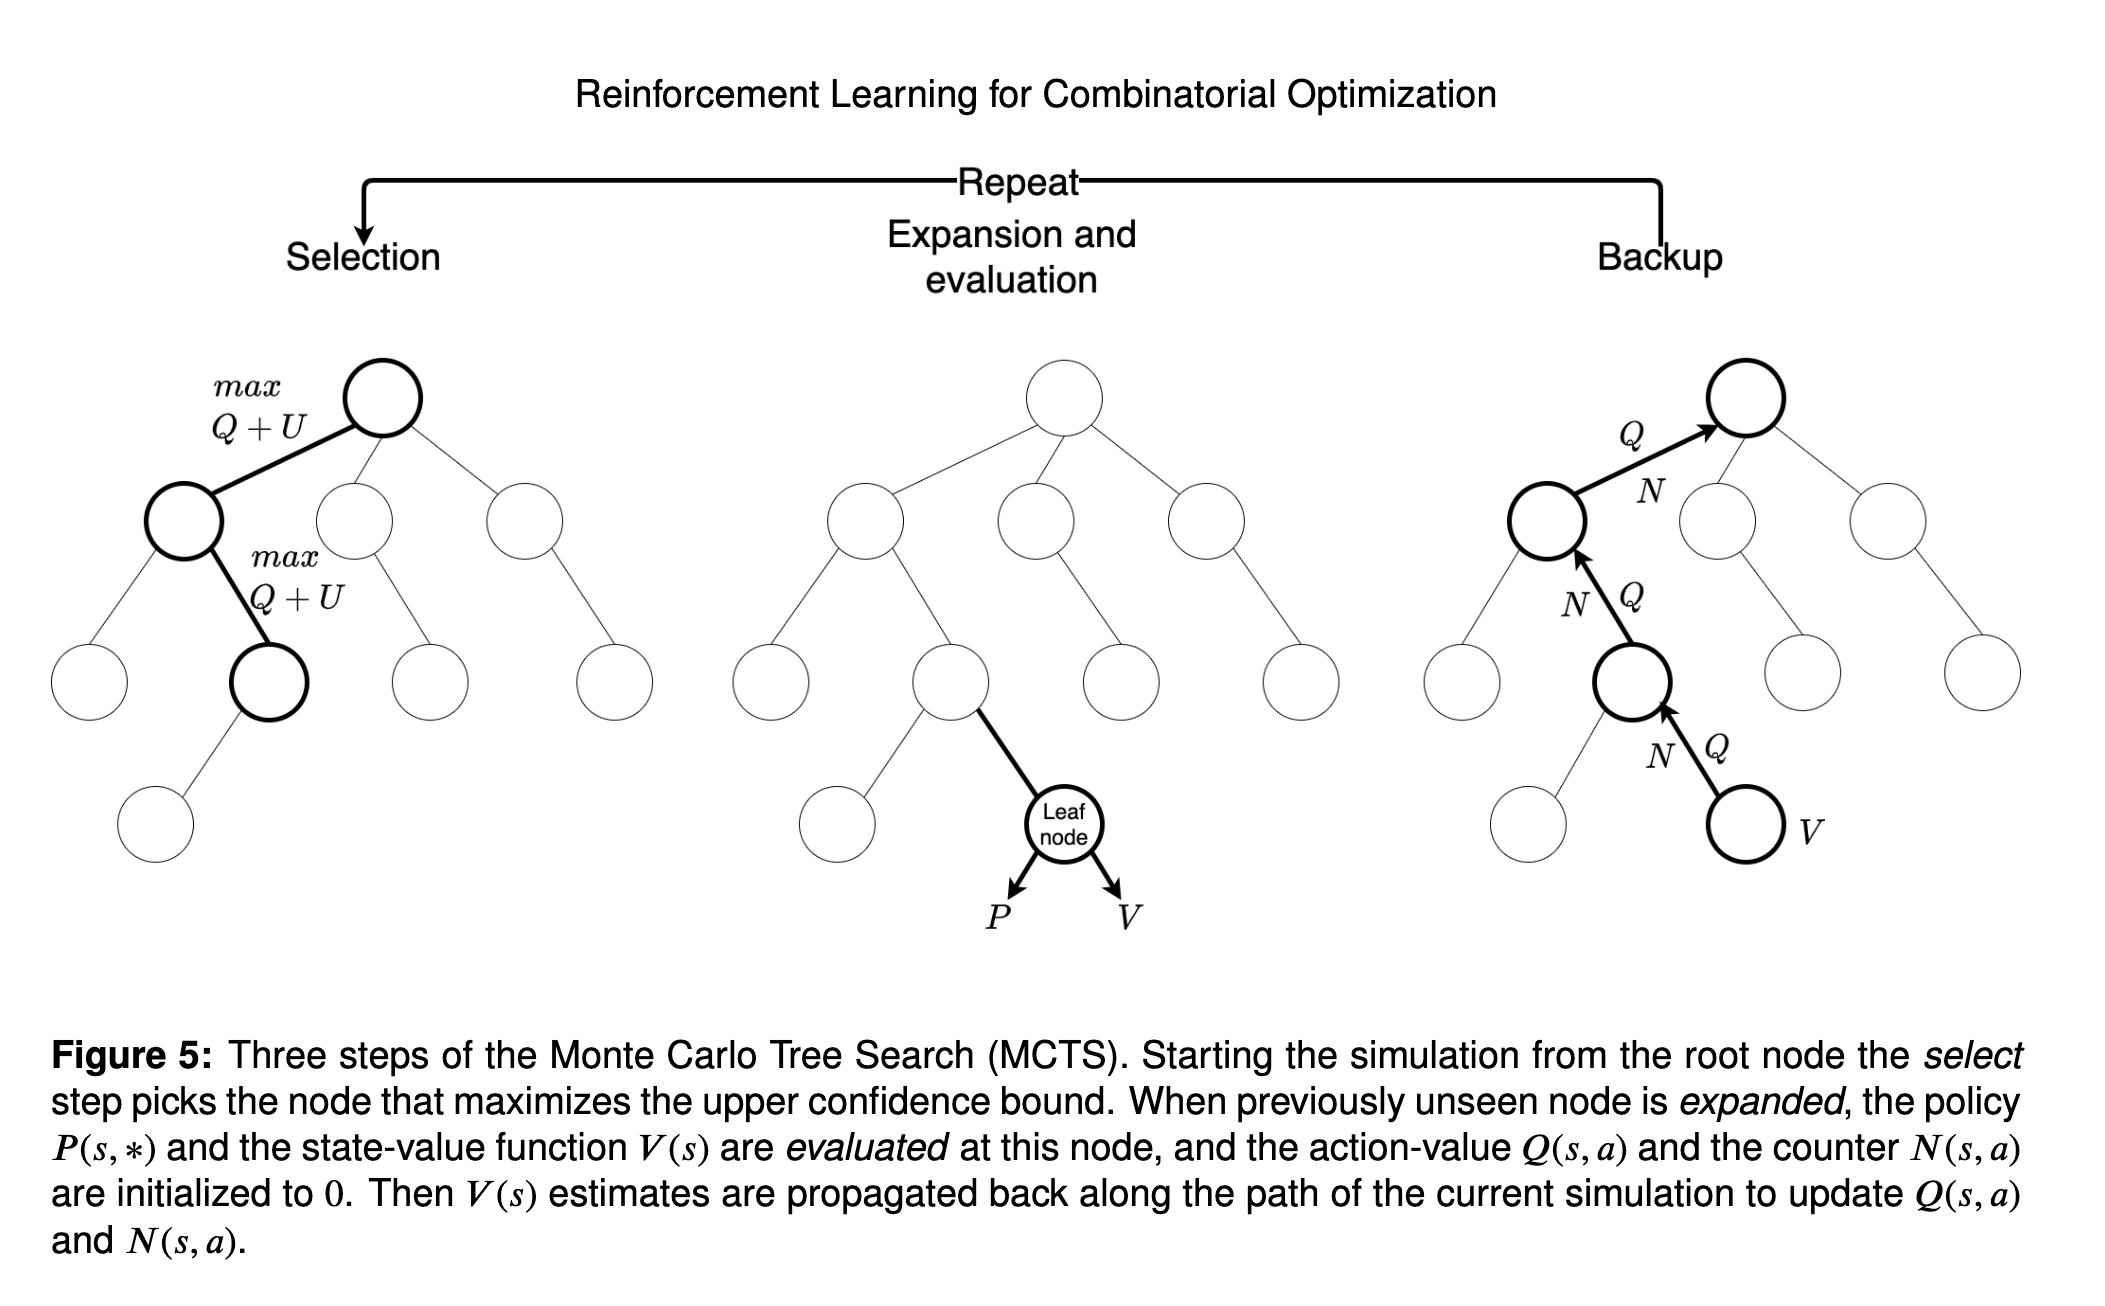


<font color='red'>**MCTS is a family of search algorithms**</font>,  below we use **Upper Confidence Bound 1 (UCB1)**. Starting with a root node (current state), MCTS iteratively explores a tree where nodes are states and edges are actions. We can't build the entire enormous tree, so we explore selectively.

MCTS Step:

1. **Expand (Leaf Node)**: If the current node is a leaf (unexplored), we expand it by applying all possible actions. Resulting states are checked for the goal. The leaf state is evaluated by the model, storing its value and policy.

2. **Select (Non-Leaf Node)**: If the node has children, we decide which action (path) to explore next, *balancing exploitation (following the model's policy) and exploration*. This decision uses a counter for each action (incremented upon selection) and the model's value prediction (tracked as the maximum value seen along a path). Actions taken more frequently are less likely to be chosen again, encouraging exploration.

3. **Backup (Game End)**: Update the visit counts and value sums of all nodes along the traversed path, influencing future UCB scores.

The UCB1 formula guides this action selection in non-leaf nodes:

$$A_t = \arg \max_a \left(U_{s_t} +W_{s_t} (a)\right),\qquad U_{s_t} = cP_{s_t}(a) \frac{\sqrt{\sum_{a'}N_{s_t}(a')}}{1 + N_{s_t}(a)}.$$

Here,

* $N_{s_t} (a)$ is a count of times that action a has been chosen in state $s_t$.
* $P_{s_t}(a)$ is the policy returned by the model for state $s_t$.
* $W_{s_t}(a)$ is the maximum value returned by the model for all children states of $s_t$ under the branch $a$.

In [ ]:
def ucb_score(parent, child):
    """
    The score for an action that would transition between the parent and child.
    """
    prior_score = child.prior * math.sqrt(parent.visit_count) / (child.visit_count + 1)
    if child.visit_count > 0:
        # The value of the child is from the perspective of the opposing player
        value_score = -child.value()
    else:
        value_score = 0

    return value_score + prior_score


class Node:
    def __init__(self, prior, to_play):
        self.visit_count = 0
        self.to_play = to_play
        self.prior = prior
        self.value_sum = 0
        self.children = {}
        self.state = None

    def expanded(self):
        return len(self.children) > 0

    def value(self):
        if self.visit_count == 0:
            return 0
        return self.value_sum / self.visit_count

    def select_action(self, temperature):
        """
        Select action according to the visit count distribution and the temperature.
        """
        visit_counts = np.array([child.visit_count for child in self.children.values()])
        actions = [action for action in self.children.keys()]
        if temperature == 0:
            action = actions[np.argmax(visit_counts)]
        elif temperature == float("inf"):
            action = np.random.choice(actions)
        else:
            # See paper appendix Data Generation
            visit_count_distribution = visit_counts ** (1 / temperature)
            visit_count_distribution = visit_count_distribution / sum(visit_count_distribution)
            action = np.random.choice(actions, p=visit_count_distribution)

        return action

    def select_child(self):
        """
        Select the child with the highest UCB score.
        """
        best_score = -np.inf
        best_action = -1
        best_child = None

        for action, child in self.children.items():
            score = ucb_score(self, child)
            if score > best_score:
                best_score = score
                best_action = action
                best_child = child

        return best_action, best_child

    def expand(self, state, to_play, action_probs):
        """
        We expand a node and keep track of the prior policy probability given by neural network
        """
        self.to_play = to_play
        self.state = state
        for a, prob in enumerate(action_probs):
            if prob != 0:
                self.children[a] = Node(prior=prob, to_play=self.to_play * -1)

    def __repr__(self):
        """
        Debugger pretty print node info
        """
        prior = "{0:.2f}".format(self.prior)
        return "{} Prior: {} Count: {} Value: {}".format(self.state.__str__(), prior, self.visit_count, self.value())


class MCTS:

    def __init__(self, game, model, args):
        self.game = game
        self.model = model
        self.args = args

    def run(self, model, state, to_play):

        root = Node(0, to_play)

        # EXPAND root
        action_probs, value = model.predict(state)
        valid_moves = self.game.get_valid_moves(state)
        action_probs = action_probs * valid_moves  # mask invalid moves
        action_probs /= np.sum(action_probs)
        root.expand(state, to_play, action_probs)

        for _ in range(self.args['num_simulations']):
            node = root
            search_path = [node]

            # SELECT
            while node.expanded():
                action, node = node.select_child()
                search_path.append(node)

            parent = search_path[-2]
            state = parent.state
            # Now we're at a leaf node and we would like to expand
            # Players always play from their own perspective
            next_state, _ = self.game.get_next_state(state, player=1, action=action)
            # Get the board from the perspective of the other player
            next_state = self.game.get_canonical_board(next_state, player=-1)

            # The value of the new state from the perspective of the other player
            value = self.game.get_reward_for_player(next_state, player=1)
            if value is None:
                # If the game has not ended:
                # EXPAND
                action_probs, value = model.predict(next_state)
                valid_moves = self.game.get_valid_moves(next_state)
                action_probs = action_probs * valid_moves  # mask invalid moves
                action_probs /= np.sum(action_probs)
                node.expand(next_state, parent.to_play * -1, action_probs)

            self.backpropagate(search_path, value, parent.to_play * -1)

        return root

    def backpropagate(self, search_path, value, to_play):
        """
        At the end of a simulation, we propagate the evaluation all the way up the tree
        to the root.
        """
        for node in reversed(search_path):
            node.value_sum += value if node.to_play == to_play else -value
            node.visit_count += 1

# Training

Standard training cycle

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Parameters

In [ ]:
args = {
    'batch_size': 64,
    'numIters': 50, #500,                            # Total number of training iterations
    'num_simulations': 100,                         # Total number of MCTS simulations to run when deciding on a move to play
    'numEps': 100,                                  # Number of full games (episodes) to run during each iteration
    'numItersForTrainExamplesHistory': 20,
    'epochs': 2,                                    # Number of epochs of training per iteration
    'checkpoint_path': 'latest.pth'                 # location to save latest set of weights
}


Trainer class

In [ ]:
class Trainer:

    def __init__(self, game, model, args):
        self.game = game
        self.model = model
        self.args = args
        self.mcts = MCTS(self.game, self.model, self.args)

    def exceute_episode(self):

        train_examples = []
        current_player = 1
        state = self.game.get_init_board()

        while True:
            canonical_board = self.game.get_canonical_board(state, current_player)

            self.mcts = MCTS(self.game, self.model, self.args)
            root = self.mcts.run(self.model, canonical_board, to_play=1)

            action_probs = [0 for _ in range(self.game.get_action_size())]
            for k, v in root.children.items():
                action_probs[k] = v.visit_count

            action_probs = action_probs / np.sum(action_probs)
            train_examples.append((canonical_board, current_player, action_probs))

            action = root.select_action(temperature=0)
            state, current_player = self.game.get_next_state(state, current_player, action)
            reward = self.game.get_reward_for_player(state, current_player)

            if reward is not None:
                ret = []
                for hist_state, hist_current_player, hist_action_probs in train_examples:
                    # [Board, currentPlayer, actionProbabilities, Reward]
                    ret.append((hist_state, hist_action_probs, reward * ((-1) ** (hist_current_player != current_player))))

                return ret

    def learn(self):
        for i in range(1, self.args['numIters'] + 1):

            print("{}/{}".format(i, self.args['numIters']))

            train_examples = []

            for eps in range(self.args['numEps']):
                iteration_train_examples = self.exceute_episode()
                train_examples.extend(iteration_train_examples)

            shuffle(train_examples)
            self.train(train_examples)
            filename = self.args['checkpoint_path']
            self.save_checkpoint(folder=".", filename=filename)

    def train(self, examples):
        optimizer = optim.Adam(self.model.parameters(), lr=5e-4)
        pi_losses = []
        v_losses = []

        for epoch in range(self.args['epochs']):
            self.model.train()

            batch_idx = 0

            while batch_idx < int(len(examples) / self.args['batch_size']):
                sample_ids = np.random.randint(len(examples), size=self.args['batch_size'])
                boards, pis, vs = list(zip(*[examples[i] for i in sample_ids]))
                boards = torch.FloatTensor(np.array(boards).astype(np.float64))
                target_pis = torch.FloatTensor(np.array(pis))
                target_vs = torch.FloatTensor(np.array(vs).astype(np.float64))

                # predict
                boards = boards.contiguous().to(device)
                target_pis = target_pis.contiguous().to(device)
                target_vs = target_vs.contiguous().to(device)

                # compute output
                out_pi, out_v = self.model(boards)
                l_pi = self.loss_pi(target_pis, out_pi)
                l_v = self.loss_v(target_vs, out_v)
                total_loss = l_pi + l_v

                pi_losses.append(float(l_pi))
                v_losses.append(float(l_v))

                optimizer.zero_grad()
                total_loss.backward()
                optimizer.step()

                batch_idx += 1

            print()
            print("Policy Loss", np.mean(pi_losses))
            print("Value Loss", np.mean(v_losses))
            print("Examples:")
            print(out_pi[0].detach())
            print(target_pis[0])

    def loss_pi(self, targets, outputs):
        loss = -(targets * torch.log(outputs)).sum(dim=1)
        return loss.mean()

    def loss_v(self, targets, outputs):
        loss = torch.sum((targets-outputs.view(-1))**2)/targets.size()[0]
        return loss

    def save_checkpoint(self, folder, filename):
        if not os.path.exists(folder):
            os.mkdir(folder)

        filepath = os.path.join(folder, filename)
        torch.save({
            'state_dict': self.model.state_dict(),
        }, filepath)

Training the model

In [ ]:
game = Connect2Game()
board_size = game.get_board_size()
action_size = game.get_action_size()

model = Connect2Model(board_size, action_size, device)

trainer = Trainer(game, model, args)
trainer.learn()

1/50

Policy Loss 1.3823141157627106
Value Loss 0.9145285934209824
Examples:
tensor([0.2889, 0.2669, 0.2443, 0.1998], device='cuda:0')
tensor([0.4500, 0.0000, 0.3300, 0.2200], device='cuda:0')

Policy Loss 1.3807154893875122
Value Loss 0.8948859497904778
Examples:
tensor([0.2922, 0.2623, 0.2396, 0.2059], device='cuda:0')
tensor([0.0000, 0.0000, 0.9600, 0.0400], device='cuda:0')
2/50

Policy Loss 1.379519909620285
Value Loss 0.9036296606063843
Examples:
tensor([0.2911, 0.2625, 0.2412, 0.2052], device='cuda:0')
tensor([0.0000, 0.0000, 0.9600, 0.0400], device='cuda:0')

Policy Loss 1.379407063126564
Value Loss 0.8941634148359299
Examples:
tensor([0.2852, 0.2688, 0.2495, 0.1965], device='cuda:0')
tensor([0.4400, 0.0000, 0.3400, 0.2200], device='cuda:0')
3/50

Policy Loss 1.3739326894283295
Value Loss 0.899302527308464
Examples:
tensor([0.2814, 0.2705, 0.2463, 0.2018], device='cuda:0')
tensor([0.0200, 0.9500, 0.0200, 0.0100], device='cuda:0')

Policy Loss 1.3702734261751175
Value Loss 0.887

# Simple Test for MCTS

We run several test for the MCTS algorithm, for example:

1. Starting board is $[0, 0, 0, 0]$, the probabilities are $[0.26, 0.24, 0.24, 0.26]$. The best move is to play at index $1$ or $2$.

2.  Starting board is $[0, 0, 1, -1]$, the probabilities are $[0.3, 0.7, 0, 0]$.   The best move is to play at index $1$.

3. Test 2 above with equal priors.

4. Starting board is: $[-1, 0, 0, 0]$, the probabilities are $[0.0, 0.3, 0.3, 0.3]$. The best move is to play at index 1.


+ tests for the UCB1 algorithm.

In [ ]:
import numpy as np
import unittest

class MCTSTests(unittest.TestCase):

    def test_mcts_from_root_with_equal_priors(self):
        class MockModel:
            def predict(self, board):
                # starting board is:
                # [0, 0, 0, 0]
                return np.array([0.26, 0.24, 0.24, 0.26]), 0.0001

        game = Connect2Game()
        args = {'num_simulations': 50}

        model = MockModel()
        mcts = MCTS(game, model, args)
        canonical_board = [0, 0, 0, 0]
        print("starting")
        root = mcts.run(model, canonical_board, to_play=1)

        # the best move is to play at index 1 or 2
        best_outer_move = max(root.children[0].visit_count, root.children[3].visit_count)
        best_center_move = max(root.children[1].visit_count, root.children[2].visit_count)
        self.assertGreater(best_center_move, best_outer_move)

    def test_mcts_finds_best_move_with_really_bad_priors(self):
        class MockModel:
            def predict(self, board):
                # starting board is:
                # [0, 0, 1, -1]
                return np.array([0.3, 0.7, 0, 0]), 0.0001

        game = Connect2Game()
        args = {'num_simulations': 25}

        model = MockModel()
        mcts = MCTS(game, model, args)
        canonical_board = [0, 0, 1, -1]
        print("starting")
        root = mcts.run(model, canonical_board, to_play=1)

        # the best move is to play at index 1
        self.assertGreater(root.children[1].visit_count, root.children[0].visit_count)

    def test_mcts_finds_best_move_with_equal_priors(self):

        class MockModel:
            def predict(self, board):
                return np.array([0.51, 0.49, 0, 0]), 0.0001

        game = Connect2Game()
        args = { 'num_simulations': 25 }

        model = MockModel()
        mcts = MCTS(game, model, args)
        canonical_board = [0, 0, -1, 1]
        root = mcts.run(model, canonical_board, to_play=1)

        # the better move is to play at index 1
        self.assertLess(root.children[0].visit_count, root.children[1].visit_count)

    def test_mcts_finds_best_move_with_really_really_bad_priors(self):
        class MockModel:
            def predict(self, board):
                # starting board is:
                # [-1, 0, 0, 0]
                return np.array([0, 0.3, 0.3, 0.3]), 0.0001

        game = Connect2Game()
        args = {'num_simulations': 100}

        model = MockModel()
        mcts = MCTS(game, model, args)
        canonical_board = [-1, 0, 0, 0]
        root = mcts.run(model, canonical_board, to_play=1)

        # the best move is to play at index 1
        self.assertGreater(root.children[1].visit_count, root.children[2].visit_count)
        self.assertGreater(root.children[1].visit_count, root.children[3].visit_count)

class NodeTests(unittest.TestCase):

    def test_initialization(self):
        node = Node(0.5, to_play=1)

        self.assertEqual(node.visit_count, 0)
        self.assertEqual(node.prior, 0.5)
        self.assertEqual(len(node.children), 0)
        self.assertFalse(node.expanded())
        self.assertEqual(node.value(), 0)

    def test_selection(self):
        node = Node(0.5, to_play=1)
        c0 = Node(0.5, to_play=-1)
        c1 = Node(0.5, to_play=-1)
        c2 = Node(0.5, to_play=-1)
        node.visit_count = 1
        c0.visit_count = 0
        c2.visit_count = 0
        c2.visit_count = 1

        node.children = {
            0: c0,
            1: c1,
            2: c2,
        }

        action = node.select_action(temperature=0)
        self.assertEqual(action, 2)

    def test_expansion(self):
        node = Node(0.5, to_play=1)

        state = [0, 0, 0, 0]
        action_probs = [0.25, 0.15, 0.5, 0.1]
        to_play = 1

        node.expand(state, to_play, action_probs)

        self.assertEqual(len(node.children), 4)
        self.assertTrue(node.expanded())
        self.assertEqual(node.to_play, to_play)
        self.assertEqual(node.children[0].prior, 0.25)
        self.assertEqual(node.children[1].prior, 0.15)
        self.assertEqual(node.children[2].prior, 0.50)
        self.assertEqual(node.children[3].prior, 0.10)

    def test_ucb_score_no_children_visited(self):
        node = Node(0.5, to_play=1)
        node.visit_count = 1

        state = [0, 0, 0, 0]
        action_probs = [0.25, 0.15, 0.5, 0.1]
        to_play = 1

        node.expand(state, to_play, action_probs)
        node.children[0].visit_count = 0
        node.children[1].visit_count = 0
        node.children[2].visit_count = 0
        node.children[3].visit_count = 0

        score_0 = ucb_score(node, node.children[0])
        score_1 = ucb_score(node, node.children[1])
        score_2 = ucb_score(node, node.children[2])
        score_3 = ucb_score(node, node.children[3])

        # With no visits, UCB score is just the priors
        self.assertEqual(score_0, node.children[0].prior)
        self.assertEqual(score_1, node.children[1].prior)
        self.assertEqual(score_2, node.children[2].prior)
        self.assertEqual(score_3, node.children[3].prior)

    def test_ucb_score_one_child_visited(self):
        node = Node(0.5, to_play=1)
        node.visit_count = 1

        state = [0, 0, 0, 0]
        action_probs = [0.25, 0.15, 0.5, 0.1]
        to_play = 1

        node.expand(state, to_play, action_probs)
        node.children[0].visit_count = 0
        node.children[1].visit_count = 0
        node.children[2].visit_count = 1
        node.children[3].visit_count = 0

        score_0 = ucb_score(node, node.children[0])
        score_1 = ucb_score(node, node.children[1])
        score_2 = ucb_score(node, node.children[2])
        score_3 = ucb_score(node, node.children[3])

        # With no visits, UCB score is just the priors
        self.assertEqual(score_0, node.children[0].prior)
        self.assertEqual(score_1, node.children[1].prior)
        # If we visit one child once, its score is halved
        self.assertEqual(score_2, node.children[2].prior / 2)
        self.assertEqual(score_3, node.children[3].prior)

        action, child = node.select_child()

        self.assertEqual(action, 0)

    def test_ucb_score_one_child_visited_twice(self):
        node = Node(0.5, to_play=1)
        node.visit_count = 2

        state = [0, 0, 0, 0]

        action_probs = [0.25, 0.15, 0.5, 0.1]
        to_play = 1

        node.expand(state, to_play, action_probs)
        node.children[0].visit_count = 0
        node.children[1].visit_count = 0
        node.children[2].visit_count = 2
        node.children[3].visit_count = 0

        score_0 = ucb_score(node, node.children[0])
        score_1 = ucb_score(node, node.children[1])
        score_2 = ucb_score(node, node.children[2])
        score_3 = ucb_score(node, node.children[3])

        action, child = node.select_child()

        # Now that we've visited the second action twice, we should
        # end up trying the first action
        self.assertEqual(action, 0)

    def test_ucb_score_no_children_visited(self):
        node = Node(0.5, to_play=1)
        node.visit_count = 1

        state = [0, 0, 0, 0]
        action_probs = [0.25, 0.15, 0.5, 0.1]
        to_play = 1

        node.expand(state, to_play, action_probs)
        node.children[0].visit_count = 0
        node.children[1].visit_count = 0
        node.children[2].visit_count = 1
        node.children[3].visit_count = 0

        score_0 = ucb_score(node, node.children[0])
        score_1 = ucb_score(node, node.children[1])
        score_2 = ucb_score(node, node.children[2])
        score_3 = ucb_score(node, node.children[3])

        # With no visits, UCB score is just the priors
        self.assertEqual(score_0, node.children[0].prior)
        self.assertEqual(score_1, node.children[1].prior)
        # If we visit one child once, its score is halved
        self.assertEqual(score_2, node.children[2].prior / 2)
        self.assertEqual(score_3, node.children[3].prior)



unittest.main(argv=['first-arg-is-ignored'], exit=False)

..........
----------------------------------------------------------------------
Ran 10 tests in 0.013s

OK


starting
starting


# AlphaZero's applicability

The AlphaZero method is quite general. However, the problem we considered relies on several assumptions. If these don't hold, modifications or alternative methods may be necessary:

* **Fully Observable and Distinct States**: The environment's state must be completely visible and allow for unambiguous identification (true for the chess or for the Rubik's Cube, but not most poker variants).

* **Discrete and Finite Actions**: The number of possible actions must be limited and countable (true for the chess, but not continuous steering angles).

* **Reliable Environment Model**: We must be able to accurately predict the outcome of any action in any state (the rules of games like chess and Go provide this; MuZero approximates this with neural networks at a performance cost).

* **Deterministic Domain**: Applying the same action in the same state must always lead to the same result (backgammon, with dice rolls, is a counterexample, though the method might be generalizable).